<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Продвинутый поток. Весна 2021</b></h3>

Это домашнее задание будет посвящено полноценному решению задачи машинного обучения.

Есть две части этого домашнего задания: 
* Сделать полноценный отчет о вашей работе: как вы обработали данные, какие модели попробовали и какие результаты получились (максимум 10 баллов). За каждую выполненную часть будет начислено определенное количество баллов.
* Лучшее решение отправить в соревнование на [kaggle](https://www.kaggle.com/c/advanced-dls-spring-2021/) (максимум 5 баллов). За прохождение определенного порогов будут начисляться баллы.


**Обе части будут проверяться в формате peer-review. Т.е. вашу посылку на степик будут проверять несколько других студентов и аггрегация их оценок будет выставлена. В то же время вам тоже нужно будет проверить несколько других учеников.**

**Пожалуйста, делайте свою работу чистой и понятной, чтобы облегчить проверку. Если у вас будут проблемы с решением или хочется совета, то пишите в наш чат в телеграме или в лс @runfme. Если вы захотите проаппелировать оценку, то пипшите в лс @runfme.**

**Во всех пунктах указания это минимальный набор вещей, которые стоит сделать. Если вы можете сделать какой-то шаг лучше или добавить что-то свое - дерзайте!**

# Как проверять?

Ставьте полный балл, если выполнены все рекомендации или сделано что-то более интересное и сложное. За каждый отсустствующий пункт из рекомендация снижайте 1 балл.

# Метрика

Перед решением любой задачи важно понимать, как будет оцениваться ваше решение. В данном случае мы используем стандартную для задачи классификации метрику ROC-AUC. Ее можно вычислить используя только предсказанные вероятности и истинные классы без конкретного порога классификации + она раотает даже если классы в данных сильно несбалансированны (примеров одного класса в десятки раз больше примеров длугого). Именно поэтому она очень удобна для соревнований.

Посчитать ее легко:


In [1]:
from sklearn.metrics import roc_auc_score

y_true = [
    0,
    1,
    1,
    0,
    1
]

y_predictions = [
    0.1,
    0.9,
    0.4,
    0.6,
    0.61
]

roc_auc_score(y_true, y_predictions)

0.8333333333333333

# Первая часть. Исследование

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from catboost import CatBoostClassifier
from sklearn.impute import SimpleImputer
from matplotlib import pyplot as plt

## Загрузка данных (2 балла)

1) Посмотрите на случайные строчки. 

2) Посмотрите, есть ли в датасете незаполненные значения (nan'ы) с помощью data.isna() или data.info() и, если нужно, замените их на что-то. Будет хорошо, если вы построите табличку с количеством nan в каждой колонке.

In [3]:
data = pd.read_csv('./train.csv')

In [4]:
# Для вашего удобства списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [5]:
data.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


## Проверим на пустые значения

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [7]:
data.isna().sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

#### Видим в колонке TotalSpent  имеется 9 пустых зачений:

In [8]:
(data == ' ').sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  9
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

## Анализ данных (3 балла)

1) Для численных призанков постройте гистограмму (*plt.hist(...)*) или boxplot (*plt.boxplot(...)*). Для категориальных посчитайте количество каждого значения для каждого признака. Для каждой колонки надо сделать *data.value_counts()* и построить bar диаграммы *plt.bar(...)* или круговые диаграммы *plt.pie(...)* (хорошо, елси вы сможете это сделать на одном гарфике с помощью *plt.subplots(...)*). 

2) Посмотрите на распределение целевой переменной и скажите, являются ли классы несбалансированными.

3) (Если будет желание) Поиграйте с разными библиотеками для визуализации - *sns*, *pandas_visual_analysis*, etc.

Второй пункт очень важен, потому что существуют задачи классификации с несбалансированными классами. Например, это может значить, что в датасете намного больше примеров 0 класса. В таких случаях нужно 1) не использовать accuracy как метрику 2) использовать методы борьбы с imbalanced dataset (обычно если датасет сильно несбалансирован, т.е. класса 1 в 20 раз меньше класса 0).

#### Для начала заменим пустые значения в колонке TotalSpent на среднее:

#### Заменим пробелы на np.nan

In [50]:
data['TotalSpent'].replace(' ', np.nan, inplace=True)

In [51]:
(data['TotalSpent'] == ' ').sum(), data['TotalSpent'].isna().sum()

(0, 9)

#### Затем преобразуем строковые значения в числовые, тк числа в этой колонке были в формате object:

In [52]:
data['TotalSpent'] = data['TotalSpent'].astype('float')

#### Посмотрим в каких индексах были пустые значения

In [53]:
data['TotalSpent'][data['TotalSpent'].isna()]

1048   NaN
1707   NaN
2543   NaN
3078   NaN
3697   NaN
4002   NaN
4326   NaN
4551   NaN
4598   NaN
Name: TotalSpent, dtype: float64

#### Запомним их, чтобы посмотреть что будет вместо пустых значений

In [54]:
nan_index = data['TotalSpent'][data['TotalSpent'].isna()].index

#### Заменим пустые значения на среднее:

In [55]:
imputer = SimpleImputer(strategy='mean')
data['TotalSpent'] = imputer.fit_transform(data['TotalSpent'][:, np.newaxis])

<ipython-input-55-c59828181d27>:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  data['TotalSpent'] = imputer.fit_transform(data['TotalSpent'][:, np.newaxis])


#### Проверим:

In [56]:
data['TotalSpent'].isna().sum()

0

#### Посмотрим какое получилось среднее:

In [57]:
data['TotalSpent'][nan_index]

1048    2291.390461
1707    2291.390461
2543    2291.390461
3078    2291.390461
3697    2291.390461
4002    2291.390461
4326    2291.390461
4551    2291.390461
4598    2291.390461
Name: TotalSpent, dtype: float64

#### Построим гистограммы и ящики с усами для числовых признаков:

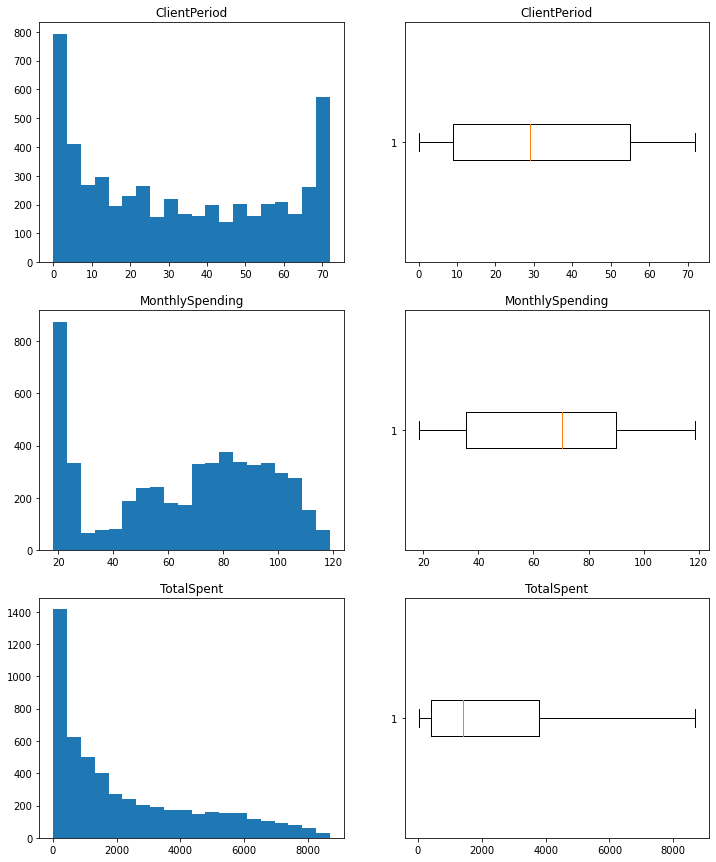

In [58]:
fig, ax = plt.subplots(3, 2, figsize=(12,15))
for i, col  in enumerate(num_cols):
    ax[i][0].set_title(col)
    ax[i][0].hist(data[col], bins=20, )
    ax[i][1].set_title(col)
    ax[i][1].boxplot(data[col], vert=False)

In [59]:
data[num_cols].describe()

,ClientPeriod,MonthlySpending,TotalSpent
count,5282.000000,5282.000000,5282.000000
mean,32.397009,64.924754,2291.390461
std,24.550326,30.176464,2267.079956
min,0.000000,18.250000,18.800000
25%,9.000000,35.462500,401.587500
50%,29.000000,70.400000,1413.650000
75%,55.000000,90.050000,3795.212500
max,72.000000,118.750000,8684.800000


#### Построим диаграммы с количеством каждого признака и круговые диаграммы для категориальных признаков:

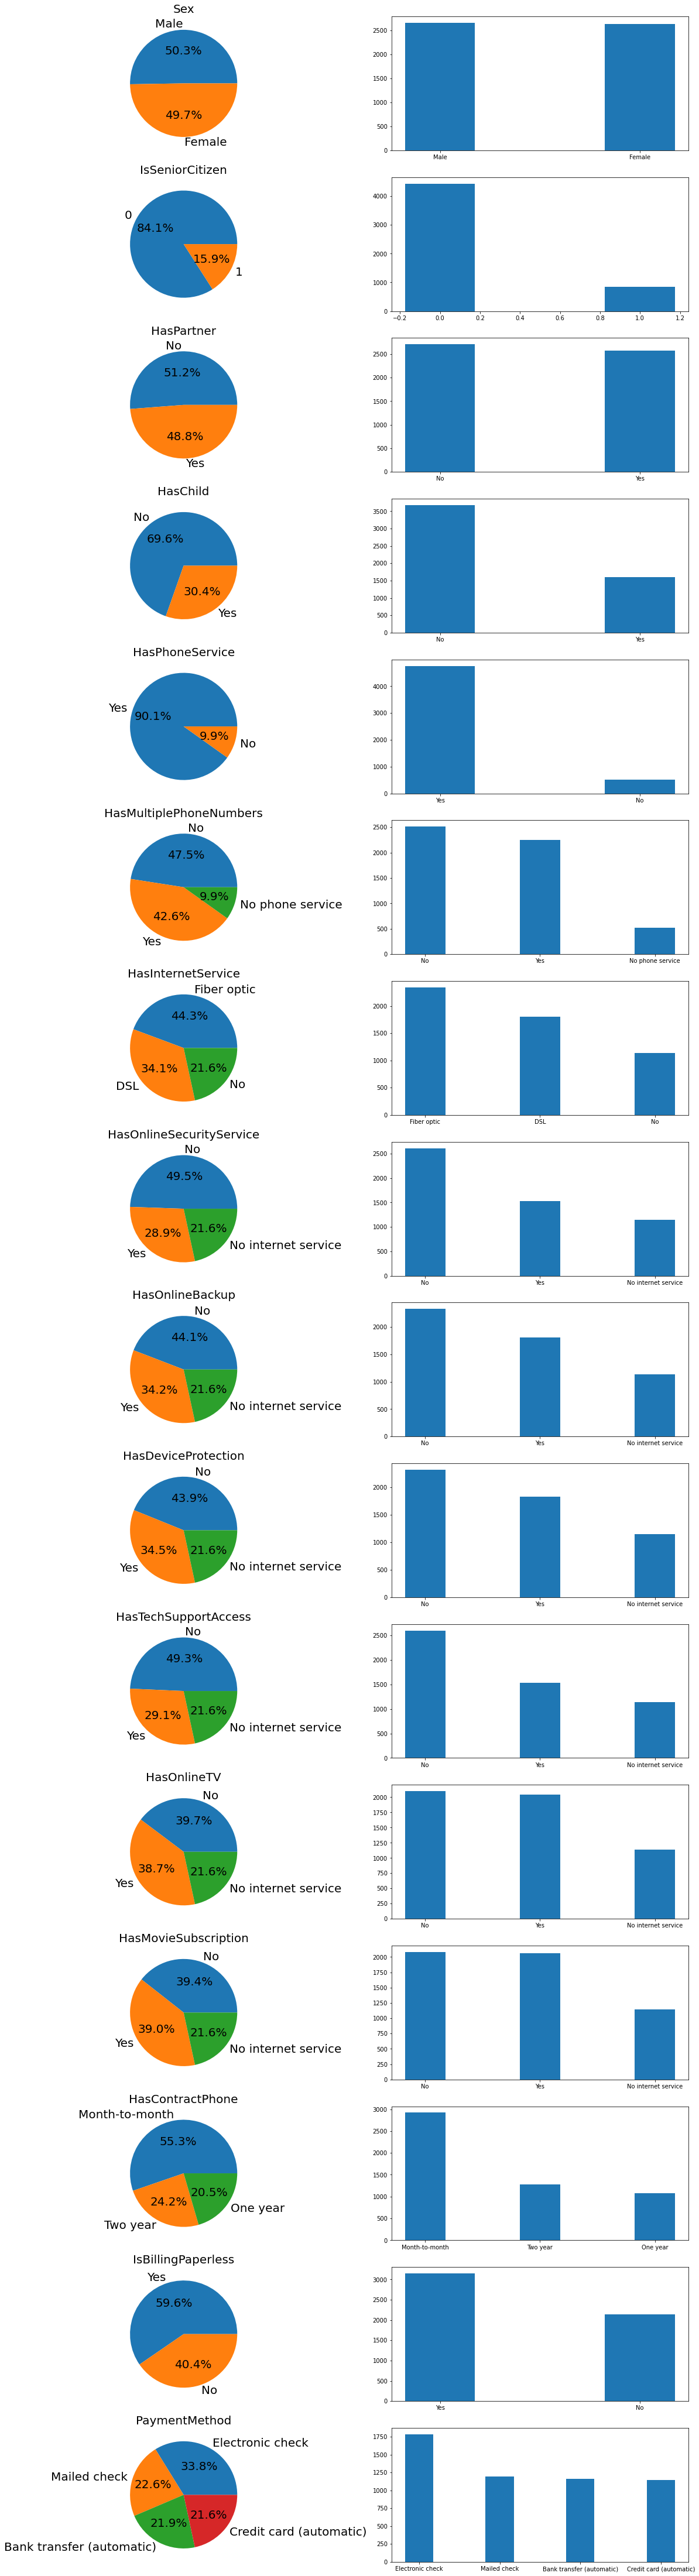

In [60]:
fig, ax = plt.subplots(len(cat_cols), 2, figsize=(20,80))
for i, col  in enumerate(cat_cols):
    labels = data[col].value_counts().index
    ax[i][0].set_title(col, fontsize=20)
    ax[i][0].pie(data[col].value_counts(), labels=labels, 
        autopct='%1.1f%%', textprops={'size': '20'}, radius=1)
    counts = data['Sex'].value_counts()
    ax[i][1].bar(labels, data[col].value_counts(),
            width=0.35)

#### Распределение целевой переменной:

In [61]:
data.iloc[:, -1].value_counts()

0    3898
1    1384
Name: Churn, dtype: int64

#### Видим что класс со значением 1 занимает 26% от общего количества

In [62]:
data.iloc[:, -1].value_counts()[1] / data.iloc[:, -1].shape[0]

0.26202196137826583

<AxesSubplot:xlabel='Churn', ylabel='Count'>

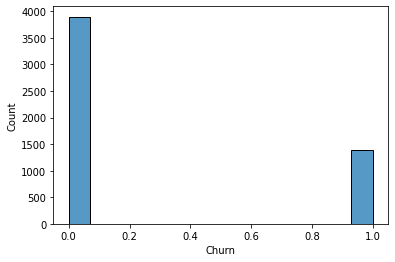

In [63]:
sns.histplot(data.iloc[:, -1], )

(Дополнительно) Если вы нашли какие-то ошибки в данных или выбросы, то можете их убрать. Тут можно поэксперементировать с обработкой данных как угодно, но не за баллы.

In [64]:
# YOUR CODE

## Применение линейных моделей (3 балла)

1) Обработайте данные для того, чтобы к ним можно было применить LogisticRegression. Т.е. отнормируйте числовые признаки, а категориальные закодируйте с помощью one-hot-encoding'а. 

2) С помощью кроссвалидации или разделения на train/valid выборку протестируйте разные значения гиперпараметра C и выберите лучший (можно тестировать С=100, 10, 1, 0.1, 0.01, 0.001) по метрике ROC-AUC. 

Если вы разделяете на train/valid, то используйте LogisticRegressionCV. Он сам при вызове .fit() подберет параметр С. (не забудьте передать scroing='roc_auc', чтобы при кроссвалидации сравнивались значения этой метрики, и refit=True, чтобы при потом модель обучилась на всем датасете с лучшим параметром C). 


(более сложный вариант) Если вы будете использовать кроссвалидацию, то преобразования данных и LogisticRegression нужно соединить в один Pipeline с помощью make_pipeline, как это делалось во втором семинаре. Потом pipeline надо передать в GridSearchCV. Для one-hot-encoding'a можно испльзовать комбинацию LabelEncoder + OneHotEncoder (сначала превращаем строчки в числа, а потом числа првращаем в one-hot вектора.)

In [148]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score

#### Нормируем числовые признаки и кодируем категориальные:

In [66]:
scaler = StandardScaler()
X_num_scaled = pd.DataFrame(scaler.fit_transform(data[num_cols]), columns=num_cols)

In [67]:
X_cat_dummies = pd.get_dummies(data[cat_cols])

In [68]:
X = pd.concat([X_num_scaled, X_cat_dummies], axis=1)

In [69]:
y = data.iloc[:, -1]

#### Разделим данные на train и valid и применим LogisticRegressionCV:

In [70]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [71]:
clf_log_reg = LogisticRegressionCV(scoring='roc_auc', refit=True)

In [72]:
clf_log_reg.fit(X_train, y_train)

LogisticRegressionCV(scoring='roc_auc')

In [73]:
roc_auc_score(y_valid, clf_log_reg.predict_proba(X_valid)[:, 1])

0.8270195140421681

In [157]:
clf_log_reg.

<bound method BaseEstimator.get_params of LogisticRegressionCV(scoring='roc_auc')>

### Можно сделать PipeLine

In [124]:
X_train, X_valid, y_train, y_valid = train_test_split(data.iloc[:,:-1], data.iloc[:,-1], test_size = 0.2, random_state = 42)

In [128]:
preprocessor  = ColumnTransformer(transformers=[
    ('StandardScaler', StandardScaler(), num_cols),
    ('OneHotEncoding', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

In [130]:
param_grid = [{'clf__C' : [100, 10, 1, 0.1, 0.01, 0.001]}]

In [131]:
pipe = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('clf', LogisticRegression())
])

In [141]:
gs = GridSearchCV(pipe, param_grid, scoring = 'roc_auc')

In [142]:
gs.fit(X_train, y_train)

c:\users\glukh\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\glukh\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('StandardScaler',
                                                                         StandardScaler(),
                                                                         ['ClientPeriod',
                                                                          'MonthlySpending',
                                                                          'TotalSpent']),
                                                                        ('OneHotEncoding',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Sex',
                                                                          'IsSeniorCitizen',
                                                                          'HasPartner',
                      

#### Лучший С:

In [158]:
gs.best_params_

{'clf__C': 10}

In [155]:
roc_auc_score(y_valid, gs.predict_proba(X_valid)[:,1])

0.8271765129616462

Выпишите какое лучшее качество и с какими параметрами вам удалось получить

## Применение градиентного бустинга (2 балла)

Если вы хотите получить баллы за точный ответ, то стоит попробовать градиентный бустинг. Часто градиентный бустинг с дефолтными параметрами даст вам 80% результата за 0% усилий.

Мы будем использовать catboost, поэтому нам не надо кодировать категориальные признаки. catboost сделает это сам (в .fit() надо передать cat_features=cat_cols). А численные признаки нормировать для моделей, основанных на деревьях не нужно.

1) Разделите выборку на train/valid. Протестируйте catboost cо стандартными параметрами.

2) Протестируйте разные занчения параметроа количества деревьев и learning_rate'а и выберите лучшую по метрике ROC-AUC комбинацию. 

(Дополнительно) Есть некоторые сложности с тем, чтобы использовать CatBoostClassifier вместе с GridSearchCV, поэтому мы не просим использовать кроссвалидацию. Но можете попробовать)

In [169]:
X_train_, X_test_, y_train_, y_valid_ = train_test_split(data.iloc[:, :-1], data.iloc[:, -1])

In [192]:
clf_catboost = CatBoostClassifier(cat_features = cat_cols, eval_metric='AUC')
cat_result = clf_catboost.grid_search({'learning_rate' : np.linspace(0.05, 0.08, 30), 'n_estimators' : [150]},
                                      X_train_, y_train_, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.83846061
bestIteration = 115

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.8384606	best: 0.8384606 (0)	total: 3.83s	remaining: 1m 51s

bestTest = 0.8381226362
bestIteration = 143

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
1:	loss: 0.8381226	best: 0.8384606 (0)	total: 7.37s	remaining: 1m 43s

bestTest = 0.8382996701
bestIteration = 147

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
2:	loss: 0.8382997	best: 0.8384606 (0)	total: 11.1s	remaining: 1m 39s

bestTest = 0.8365414018
bestIteration = 124

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
3:	loss: 0.8365414	best: 0.8384606 (0)	total: 15.2s	remaining: 1m 38s

b

In [193]:
clf_catboost.get_params()

{'eval_metric': 'AUC',
 'cat_features': ['Sex',
  'IsSeniorCitizen',
  'HasPartner',
  'HasChild',
  'HasPhoneService',
  'HasMultiplePhoneNumbers',
  'HasInternetService',
  'HasOnlineSecurityService',
  'HasOnlineBackup',
  'HasDeviceProtection',
  'HasTechSupportAccess',
  'HasOnlineTV',
  'HasMovieSubscription',
  'HasContractPhone',
  'IsBillingPaperless',
  'PaymentMethod'],
 'iterations': 150,
 'learning_rate': 0.07586206896551724}

In [194]:
roc_auc_score(y_valid_, clf_catboost.predict_proba(X_test_)[:, 1])

0.8498542274052479

Выпишите какое лучшее качество и с какими параметрами вам удалось получить

# Предсказания

In [ ]:
best_model = # какая-то предыдущая модель

SyntaxError: invalid syntax (<ipython-input-12-7d881febecc7>, line 1)

In [ ]:
X_test = pd.read_csv('./test.csv')
submission = pd.read_csv('./submission.csv')

submission['Churn'] = # best_model.predict_proba(X_test) / best_model.predict(X_test)
submission.to_csv('./my_submission.csv')

# Kaggle (5 баллов)

Как выставить баллы:

1) 1 >= roc auc > 0.84 это 5 баллов

2) 0.84 >= roc auc > 0.7 это 3 балла

3) 0.7 >= roc auc > 0.6 это 1 балл

4) 0.6 >= roc auc это 0 баллов


Для выполнения задания необходимо выполнить следующие шаги.
* Зарегистрироваться на платформе [kaggle.com](kaggle.com). Процесс выставления оценок будет проходить при подведении итогового рейтинга. Пожалуйста, укажите во вкладке Team -> Team name свои имя и фамилию в формате Имя_Фамилия (важно, чтобы имя и фамилия совпадали с данными на Stepik).
* Обучить модель, получить файл с ответами в формате .csv и сдать его в конкурс. Пробуйте и экспериментируйте. Обратите внимание, что вы можете выполнять до 20 попыток сдачи на kaggle в день.
* После окончания соревнования отправить в итоговый ноутбук с решением на степик. 
* После дедлайна проверьте посылки других участников по критериям. Для этого надо зайти на степик, скачать их ноутбук и проверить скор в соревновании.